# Studying graph probability distributions using statistical models

### Introduction

Graphs are extremely useful objects for describing many complex systems. From molecules, neural networks in a brain, or even social networks, graphs can describe many complex objects and capture their local and global properties. Understanding the structural properties of these graphs, and the design principles that govern their connectivity, is extremely useful for understanding the phenomena that these graphs describe. For example, understanding how and why neurons connect is a crucial step in understanding the relationship between structure and function of neural circuits.

By building a statistical model that outputs the probability of a given graph as a function of a set of structural properties, we can study how important those structural features are for describing the graph. We would expect structural properties that are crucial for describing the graph connectivity to have significantly "stronger" model parameters, compared to structural properties that are not relevant at all. Exponential Random Graph Models (**ERGM**) are a class of statistical models that can be used for exactly these problems. An ERGM specifies the probability of a graph as a function of some structural properties, weighted by the model parameters.

### Tutorial goals

This tutorial has 2 main learning goals. We will fit an ERGM to some observed data, by finding the optimal model parameters. For doing so, we will learn about two important statistical tools -
* Maximum Likelihood Estimation **(MLE)** via **gradient descent**
* Markov Chain Monte Carlo simulations **(MCMC)**

We will use 2 graphs for our demonstrations -
* Sampson's graph - A small graph as our initial toy example, consisting of 18 nodes. Each node represents a monk in a New England monastery, where two monks are connected if there exists a friendly relationship between them.
* C. Elegans connectome - A graph consisting of 279 nodes, representing the sensory neurons, inter-neurons and motor neurons from the C. Elegans nervous system.

### Step 1 - What is a graph and an ERGM?

Formally, a graph $G$ describes $n$ nodes that are connected to one another by a set of edges. The connectivity is specified as binary connectivity matrix $W$, where $W_{i,j}=1$ if nodes $i$ and $j$ are connected, and 0 otherwise. The graph can be directed, such that the edges have a direction, or undirected, meaning that $W_{i,j} = W_{j,i}$.

An ERGM defines a random variable $\mathbf{Y}$, which is simply a random graph on $n$ nodes. The probability of observing a specific graph $y$ is given by -
$$\Pr(\mathbf{Y}=y | \theta) = \frac{\exp(\theta^Tg(y))}{\sum_{z\in\mathcal{Y}} \exp(\theta^Tg(z))}$$
where $\mathcal{Y}$ is the set of all $n$ node graphs, $g(y)$ is a vector of statistics that describe the graph $y$, and $\theta \in \mathbb{R}^q$ is a vector of model parameters.

Essentially, an ERGM is a probability distribution over all graphs on $n$ nodes.

<div style="text-align: center;">
  <img src="./Haber_ERGM_illustration.png" width="300">
  <p style="font-size:12px;"><em>(Haber et al., 2023)</em></p>
</div>

### Step 2 - Getting to know the data

We begin by loading the Sampson monastery graph, represented as an $18 \times 18$ binary connectivity matrix. $W_{i,j}$ indicates that monk $i$ claimed to have a friendly relationship with monk $j$.

In [422]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)

W = np.array(
    [[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
     [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0],
     [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1],
     [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
     [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
     [1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
     [1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
     [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0],
     [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
     [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
     [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
     [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
     [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
     [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
     [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
     [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]]
)

n_nodes = W.shape[0]

We will use 2 structural features for our model -
* Number of edges - how many friendly relationships exist in the graph
* Number of reciprocal edges - the number of reciprocal relationships, where $W_{i,j} = W_{j, i}$

**[TASK]** In the next cell, complete the `get_number_of_edges` function.

In [ ]:
def get_number_of_edges(W: np.ndarray):
    """
    Counts the number of edges in a directed graph

    Parameters:
         W: An n by n binary connectivity matrix

    Returns:
        Number of edges in the graph
    """
    number_of_edges = None

    #####################
    ### COMPLETE THIS ###
    #####################

    return number_of_edges


def get_number_of_reciprocal_edges(W: np.ndarray):
    """
    Counts the number of reciprocal edges in a directed graph. Here we use a neat trick of calculating W^2 to find nodes that have a path of length 2

    Parameters:
         W: An n by n binary connectivity matrix

    Returns:
        Number of reciprocal edges in the graph
    """
    return (W * W.T).sum() / 2

def calculate_graph_statistics(W: np.ndarray, feature_calculators):
    """
    Given a directed graph W and a list of callable feature calculators, we calculate the graph statistics.

    Parameters:
        W: Connectivity matrix for which the statistics should be calculated
        feature_calculators: a list of callable feature calculators. Each feature calculator should be a callable object that receives a connectivity matrix, and returns the feature statistics.

    Returns:
        A numpy array containing the graph statistics.
    """
    num_features = len(feature_calculators)
    statistics = np.zeros(num_features)

    for i, feature_calculator in enumerate(feature_calculators):
        statistics[i] = feature_calculator(W)

    return statistics


Let's calculate the graph statistics using the 2 features we just defined.
<br>
Verify that the graph has **88 edges** and **28 reciprocal edges**.

In [ ]:
feature_calculators = [get_number_of_edges, get_number_of_reciprocal_edges]
observed_stats = calculate_graph_statistics(W, feature_calculators)
print(f"Number of edges - {observed_stats[0]}")
print(f"Number of reciprocal edges - {observed_stats[1]}")

### Step 3 - Fitting the model

A common technique for finding the parameters of a probability distribution is to maximize a likelihood function, such that under the assumed statistical model, the observed data is the most probable outcome. Formally, this is called Maximum Likelihood Estimation (**MLE**).

The likelihood function calculates the probability of seeing the observed data, under different model parameters. Here, the likelihood function can be described as -
$$
\mathcal{L}(\theta | y_{\text{obs}}) = \frac{\exp(\theta^T g(y_{\text{obs}}))}{\sum_{z \in \mathcal{Y}} \exp(\theta^T g(z))}
$$

where $y_{\text{obs}}$ is the observed graph.

In this toy example, we defined 2 features - number of edges and number of reciprocal edges. Hence, $g(y)$ is a vector with 2 numbers.

It is a common practice to look at the log-likelihood function instead, since it is more convenient to work with -
$$
\ell (\theta | y_{\text{obs}} ) =  \theta^T g(y_{\text{obs}}) - \log(\sum_{z \in \mathcal{Y}} \exp(\theta^T g(z)))
$$

We now wish to find the model parameters that maximize the likelihood function, denoted as $\theta^*$. This is also equivalent minimizing the negative log-likelihood function, which is convenient since many optimization algorithms work by minimizing a function.
$$
\theta^* = \arg \max \ell (\theta | y_{\text{obs}} ) = -\arg \min \ell (\theta | y_{\text{obs}} )
$$

We will start with the simplest optimization algorithm - **gradient descent**. Gradient descent is an iterative algorithm for minimizing a differentiable function. The idea is to iteratively step in the opposite direction of the gradient of the function, until we hopefully converge into a minimum point of the function. Formally the algorithm is defined as -
$$ \theta_{i+1} = \theta_i - \eta \nabla \ell (\theta)$$


We now need to find the gradient of the log-likelihood function. It's ok to skip this part for now, but the idea is relatively simple and with a bit of patience it should be clear.
The log-likelihood function can be differentiated with respect to $\theta$ to obtain the gradient -

$$
\nabla \ell(\theta) = \frac{\partial}{\partial \theta} \ \ell (\theta) = g(y_{\text{obs}}) - \frac{\sum_{z\in\mathcal{Y}} \exp(\theta^Tg(z))g(z)}{\sum_{z\in\mathcal{Y}} \exp(\theta^Tg(z))}
$$

$$
= g(y_{\text{obs}}) - \sum_{z\in\mathcal{Y}} \frac{\exp(\theta^Tg(z))}{Z}g(z)
$$

$$
= g(y_{\text{obs}})- \sum_{z\in\mathcal{Y}}\Pr_{\theta, \mathcal{Y}}(\mathbf{Y}=z)g(z)
$$

$$
= g(y_{\text{obs}})- \mathbb{E}_{z\sim\mathcal{Y}}[g(z)]
$$

where $Z=\sum_{z\in\mathcal{Y}} \exp(\theta^Tg(z))$ is the normalization factor.

Notice that the gradient simplifies into 2 terms - the statistics of the observed graph $g(y_{\text{obs}})$ which we already calculated, and the expected statistics across all graphs $\mathbb{E}_{z\sim\mathcal{Y}}[g(z)]$. It turns out that calculating this expected value is computationally infeasible! It would require us iterating over all directed graphs on $n$ nodes, and even for a small graph such as the Sampson graph, we would have $2^{n^2-n}=2^{306}$ possible graphs.

In [360]:
def MCMC_graph_sample(thetas: np.ndarray,
                      feature_calculators,
                      n_nodes: int,
                      num_graphs=1000,
                      seed_graph=None,
                      seed_graph_edge_probability=0.1,
                      burn_in=1000,
                      steps_per_sample=10
                      ):
    """
    Run an MCMC sampling process sample graphs from the current distribution.

    Parameters:
        thetas: current  distribution parameters, of size `# of features`.
        feature_calculators: a list of callable feature calculators.
        n_nodes: number of nodes in the graph.
        num_graphs: number of graphs to sample.
        seed_graph_edge_probability: Edge probability of the seed graph, generated from an Erdős–Rényi model.
        burn_in: number of graphs that aren't collected to the final sample, as part of the burn in process.
        steps_per_sample: number of edge flips before evaluating a candidate graph.

    Returns:
        A list of `num_graphs`, sampled from the distribution.
    """
    if seed_graph is None:
        seed_graph = np.random.choice([0, 1], size=(n_nodes, n_nodes), p=[1-seed_graph_edge_probability, seed_graph_edge_probability])
        seed_graph[np.diag_indices(n_nodes)] = 0

    sampled_graphs = []

    current_graph = seed_graph
    current_statistics = calculate_graph_statistics(current_graph, feature_calculators)

    mcmc_iter_count = 0

    num_accepted = 0
    num_rejected = 0
    while len(sampled_graphs) < num_graphs:
        proposed_graph = current_graph.copy()

        for k in range(steps_per_sample):
            i, j = np.random.choice(n_nodes, 2, replace=False)

            proposed_graph[i, j] = 1 - proposed_graph[i, j]

        proposed_statistics = calculate_graph_statistics(proposed_graph, feature_calculators)

        change_score = proposed_statistics - current_statistics
        acceptance_proba = min(1, np.exp(thetas @ change_score))

        if np.random.random() < acceptance_proba:
            num_accepted += 1
            current_graph = proposed_graph
            current_statistics = proposed_statistics
            if mcmc_iter_count > burn_in:
                sampled_graphs.append(current_graph.copy())
        else:
            num_rejected += 1

        mcmc_iter_count += 1

    print(f"Number of accepted graphs: {num_accepted}, number of rejected graphs: {num_rejected}")
    return sampled_graphs

def calculate_mean_statistics(sample_graphs: list, feature_calculators):
    """
    Calculate the mean statistics over a collection of graphs.

    Parameters:
        sample_graphs: a list of graphs, each graph is a numpy array.
        feature_calculators: a list of callable feature calculators.

    Returns:
        The mean statistics over the provided graphs, of size `# of features`.
    """
    statistics = np.zeros((len(sample_graphs), len(feature_calculators)))

    for i, W in enumerate(sample_graphs):
        statistics[i] = calculate_graph_statistics(W, feature_calculators)

    return np.mean(statistics, axis=0)


In [413]:
# feature_calculators = [get_number_of_edges, get_number_of_reciprocal_edges]
feature_calculators = [get_number_of_edges]
observed_stats = calculate_graph_statistics(W, feature_calculators)
num_features = len(observed_stats)

initial_thetas = np.random.uniform(-1, 1, num_features)
num_opt_steps = 100
learning_rate = 0.001
MCMC_number_of_graphs_per_sample = 100
MCMC_burn_in = 0
MCMC_seed_graph_density = np.sum(W) / (n_nodes * (n_nodes-1))

seed_graph = np.random.choice([0, 1], size=(n_nodes, n_nodes), p=[1-MCMC_seed_graph_density, MCMC_seed_graph_density])
seed_graph[np.diag_indices(n_nodes)] = 0

print(f"Observed statistics - {observed_stats}")
print(f"Seed MCMC graph density - {MCMC_seed_graph_density}")
print(f"Initial thetas: {initial_thetas}")
gradients = []
thetas = initial_thetas

all_graphs = []
all_thetas = []
for i in range(num_opt_steps):
    all_thetas.append(thetas)
    print(f"Working on step {i+1}/{num_opt_steps}")

    if i == 0:
        burn_in = MCMC_burn_in
    else:
        burn_in = 0

    sample_graphs = MCMC_graph_sample(
        thetas=thetas,
        feature_calculators=feature_calculators,
        n_nodes=n_nodes,
        num_graphs=MCMC_number_of_graphs_per_sample,
        seed_graph=seed_graph,
        burn_in=burn_in,
        steps_per_sample=5
    )

    print(f"\tSampled {len(sample_graphs)} graphs")

    sample_statistics = calculate_mean_statistics(sample_graphs, feature_calculators)
    print(f"\tMean statistics: {sample_statistics}")
    gradient = sample_statistics - observed_stats
    gradients.append(gradient)
    print(f"\tGradient: {gradient}")

    thetas = thetas - learning_rate * gradient

    # Use the last sampled graph for the next starting point of the MCMC chain
    seed_graph = sample_graphs[-1]

    all_graphs.extend(sample_graphs)

Observed statistics - [88.]
Seed MCMC graph density - 0.2875816993464052
Initial thetas: [0.73213383]
Working on step 1/100
Number of accepted graphs: 100, number of rejected graphs: 68
	Sampled 100 graphs
	Mean statistics: [162.68]
	Gradient: [74.68]
Working on step 2/100
Number of accepted graphs: 100, number of rejected graphs: 106
	Sampled 100 graphs
	Mean statistics: [204.64]
	Gradient: [116.64]
Working on step 3/100
Number of accepted graphs: 100, number of rejected graphs: 107
	Sampled 100 graphs
	Mean statistics: [204.06]
	Gradient: [116.06]
Working on step 4/100
Number of accepted graphs: 100, number of rejected graphs: 75
	Sampled 100 graphs
	Mean statistics: [190.44]
	Gradient: [102.44]
Working on step 5/100
Number of accepted graphs: 101, number of rejected graphs: 42
	Sampled 100 graphs
	Mean statistics: [170.86]
	Gradient: [82.86]
Working on step 6/100
Number of accepted graphs: 101, number of rejected graphs: 29
	Sampled 100 graphs
	Mean statistics: [163.14]
	Gradient: [

In [ ]:
empirical_theta =

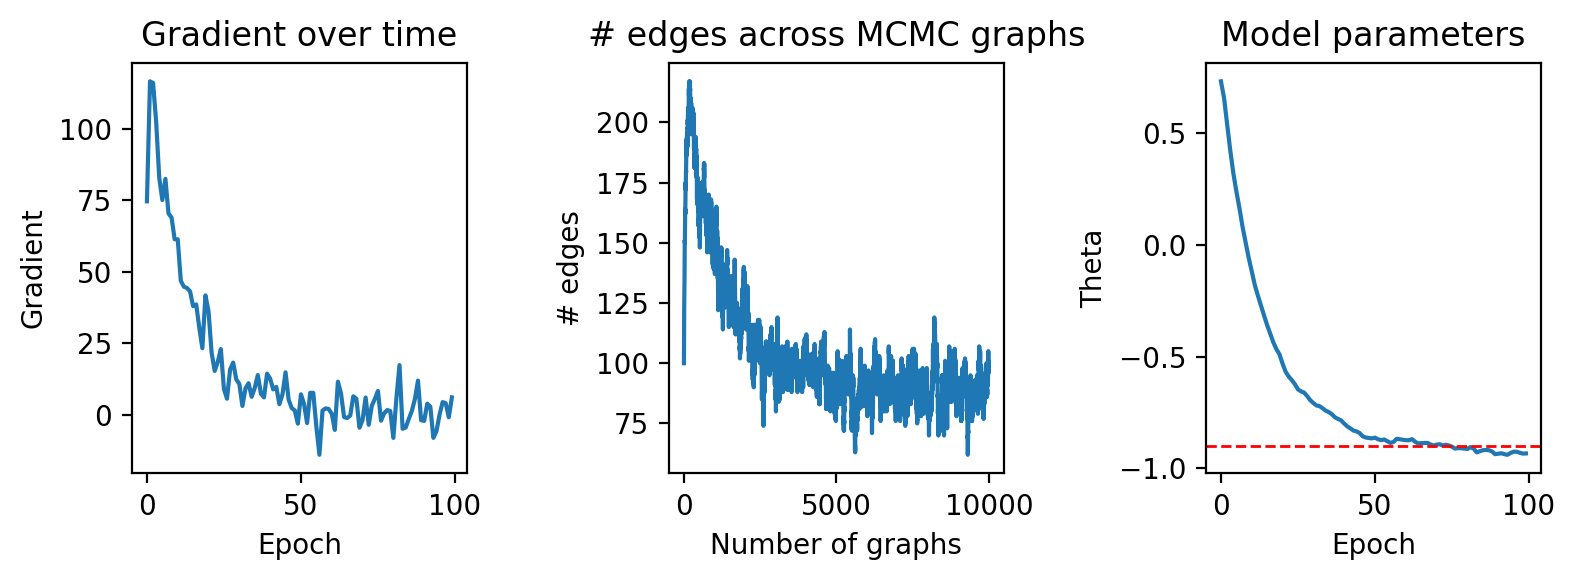

In [420]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3), dpi=200)
# fig, ax = plt.subplots(nrows=1, ncols=3)

ax[0].plot(np.mean(gradients, axis=1))
ax[0].set_title("Gradient over time")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Gradient")

ax[1].plot([np.sum(g) for g in all_graphs])
ax[1].set_title("# edges across MCMC graphs")
ax[1].set_xlabel("Number of graphs")
ax[1].axhline(y=88, color='red', linestyle='--', linewidth=1)
ax[1].set_ylabel("# edges")

ax[2].plot(all_thetas)
ax[2].set_title("Model parameters")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Theta")

plt.tight_layout()
plt.show()